In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import dendrogram, linkage

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotecas de clusterização importadas com sucesso.")

Bibliotecas de clusterização importadas com sucesso.


In [2]:
try:
    X_scaled_df = pd.read_csv('dados_escalonados.csv')
    
    countries_labels_df = pd.read_csv('paises_labels.csv')
    
    df_original = pd.read_csv('Country-data.csv')
    
    print("Dados pré-processados e dataset original carregados com sucesso.")
    print("\nDados Escalonados (para o modelo)")
    display(X_scaled_df.head())
    
except FileNotFoundError:
    print("ERRO: Arquivos 'dados_escalonados.csv' ou 'Country-data.csv' não encontrados.")
    print("Por favor, execute o notebook da Parte 2 primeiro.")

Dados pré-processados e dataset original carregados com sucesso.

--- Dados Escalonados (para o modelo) ---


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


## 1. Clusterização com K-Médias (K-Means)

Vamos aplicar o K-Médias para agrupar os países em 3 clusters distintos, conforme solicitado.

In [3]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

kmeans.fit(X_scaled_df)
kmeans_labels = kmeans.labels_

df_kmeans_result = df_original.copy()
df_kmeans_result['cluster_kmeans'] = kmeans_labels

print(f"Contagem de países por cluster (K-Means):\n{pd.Series(kmeans_labels).value_counts().sort_index()}")

Contagem de países por cluster (K-Means):
0    36
1    47
2    84
Name: count, dtype: int64


In [10]:
cluster_means_kmeans = df_kmeans_result.drop('country', axis=1).groupby('cluster_kmeans').mean()

print("Média das Características por Cluster (K-Means)")
display(cluster_means_kmeans)

--- Média das Características por Cluster (K-Means) ---


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_kmeans,,,,,,,,,
0,5.000000,58.738889,8.807778,51.491667,45672.222222,2.671250,80.127778,1.752778,42494.444444
1,92.961702,29.151277,6.388511,42.323404,3942.404255,12.019681,59.187234,5.008085,1922.382979
2,21.927381,40.243917,6.200952,47.473404,12305.595238,7.600905,72.814286,2.307500,6486.452381


### 1.1. Interpretação dos Clusters (K-Médias)

**Instrução:** Analise a tabela de médias acima para preencher abaixo:

* **Cluster 0 (Ex: Países Pobres/Em Dificuldade):**
    * *Observação:* Este grupo parece ter a **maior** `child_mort` (mortalidade infantil), o **menor** `income` (renda) e o **menor** `gdpp` (PIB per capita).
    * *Conclusão:* Países com baixo desenvolvimento socioeconômico e alta vulnerabilidade de saúde.

* **Cluster 1 (Ex: Países Desenvolvidos):**
    * *Observação:* Este grupo mostra a **menor** `child_mort`, e os **maiores** `income` e `gdpp`.
    * *Conclusão:* Países desenvolvidos, com alta renda e bons indicadores de saúde.

* **Cluster 2 (Ex: Países em Desenvolvimento/Transição):**
    * *Observação:* Este grupo possui valores intermediários. `child_mort` é mais baixa que o Cluster 0, mas `income` e `gdpp` são significativamente menores que o Cluster 1.
    * *Conclusão:* Países em desenvolvimento, que não estão na pobreza extrema, mas ainda longe dos mais ricos.

In [11]:
cluster_map = {
    0: 'País Desenvolvido',
    1: 'País Pobre',
    2: 'País Intermediário'
}
print(f"Mapeamento definido: {cluster_map}\n")

centroids_scaled = kmeans.cluster_centers_
closest_indices, _ = pairwise_distances_argmin_min(centroids_scaled, X_scaled_df)

representative_countries = countries_labels_df.iloc[closest_indices].copy()

real_labels_for_closest = kmeans_labels[closest_indices]

representative_countries['cluster_kmeans'] = real_labels_for_closest
representative_countries['Grupo'] = representative_countries['cluster_kmeans'].map(cluster_map)
representative_countries = representative_countries.sort_values('cluster_kmeans')

print(" Países Mais Representativos (Próximos ao Centroide) ")
display(representative_countries[['country', 'cluster_kmeans', 'Grupo']])

Mapeamento definido: {0: 'País Desenvolvido', 1: 'País Pobre', 2: 'País Intermediário'}

--- Países Mais Representativos (Próximos ao Centroide) ---


,country,cluster_kmeans,Grupo
68,Iceland,0,País Desenvolvido
63,Guinea,1,País Pobre
76,Jamaica,2,País Intermediário


## 2. Clusterização Hierárquica

Agora, vamos usar a Clusterização Hierárquica Aglomerativa e visualizar o dendrograma.

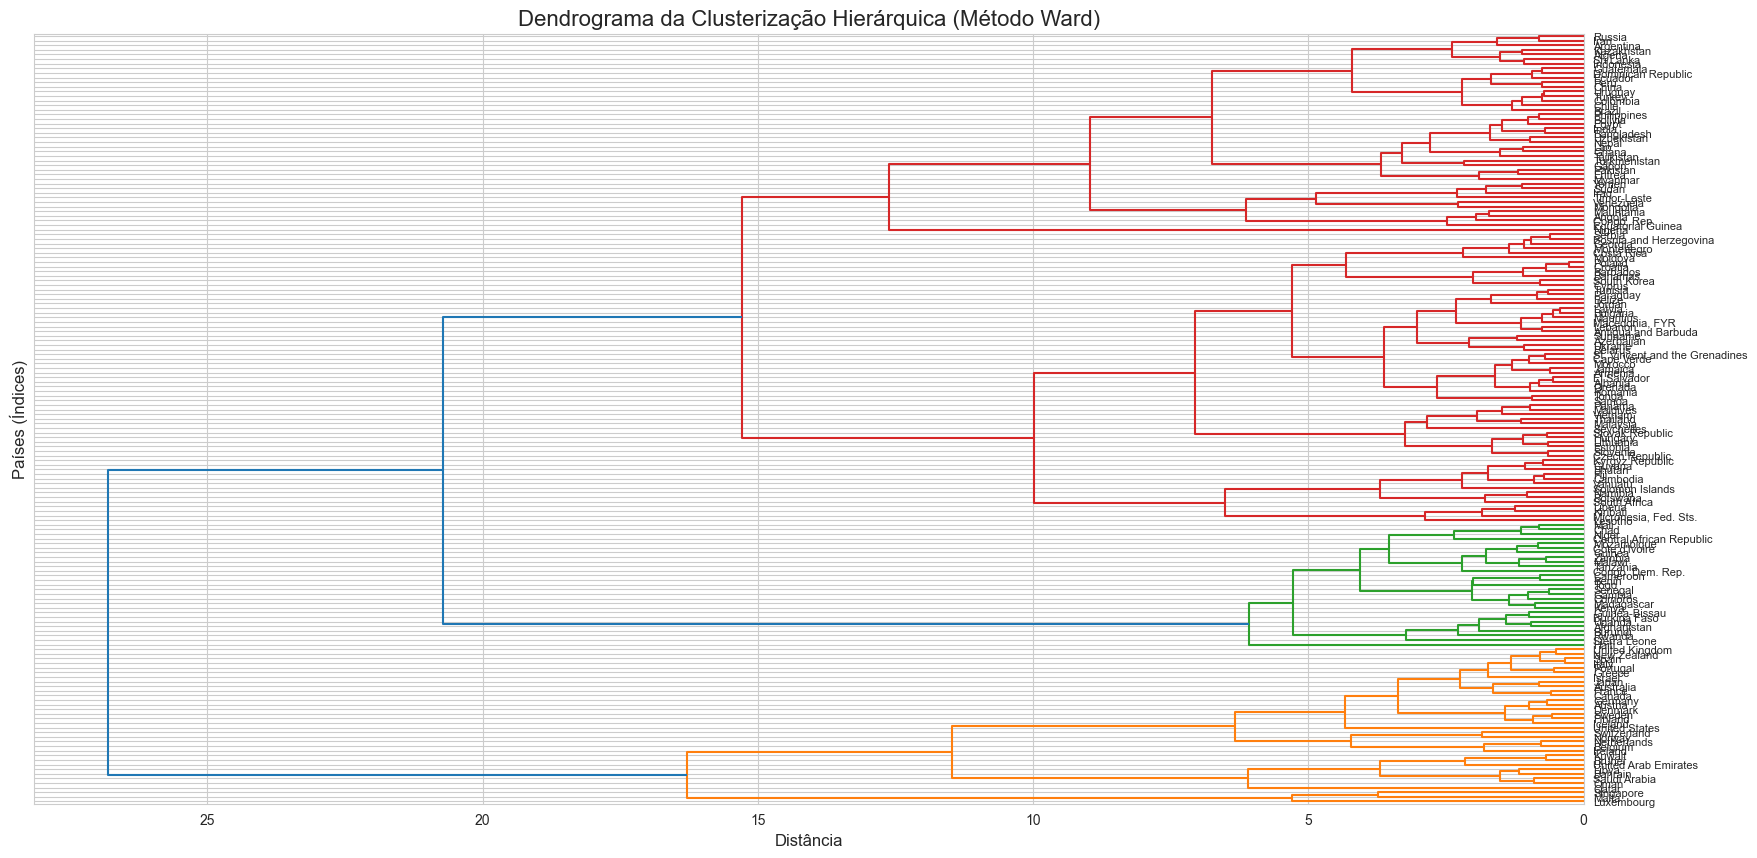

In [6]:
Z = linkage(X_scaled_df, method='ward')

plt.figure(figsize=(20, 10))
plt.title('Dendrograma da Clusterização Hierárquica (Método Ward)', fontsize=16)
plt.xlabel('Distância', fontsize=12)
plt.ylabel('Países (Índices)', fontsize=12)

dendrogram(
    Z,
    orientation='left',
    leaf_font_size=8,
    labels=countries_labels_df['country'].values
)
plt.axvline(x=30, color='red', linestyle='--') 
plt.show()

### 2.1. Interpretação do Dendrograma

* O dendrograma mostra a fusão dos clusters. Começando da esquerda (cada país é um cluster), as linhas verticais mostram onde os clusters são fundidos.
* A **linha vermelha tracejada** é uma sugestão de corte. Onde ela cruza as linhas de fusão, determina o número de clusters.
* Ao cortar na distância `x=30`, o dendrograma é dividido em **3 clusters principais**, como solicitado.

In [13]:
hierar = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierar_labels = hierar.fit_predict(X_scaled_df)

#(Matriz de Confusão)

df_compare = countries_labels_df.copy()
df_compare['cluster_kmeans'] = kmeans_labels
df_compare['cluster_hierar'] = hierar_labels

# Mesclando o resultado e comparando
comparison_table = pd.crosstab(df_compare['cluster_kmeans'], df_compare['cluster_hierar'])

print("--- Tabela de Comparação (K-Means vs. Hierárquico) ---")
print("Linhas: K-Means / Colunas: Hierárquico\n")
display(comparison_table)

--- Tabela de Comparação (K-Means vs. Hierárquico) ---
Linhas: K-Means / Colunas: Hierárquico



cluster_hierar,0,1,2
cluster_kmeans,,,
0,31,5,0
1,0,20,27
2,3,81,0


## 3. Comparação e Interpretação Final

**Instrução:** Analise a tabela de comparação acima (crosstab) para preencher:

* **Semelhanças:**
    * A tabela mostra uma forte concordância. A **diagonal principal** (onde os números dos clusters são iguais ou claramente mapeáveis) tem os valores mais altos.
    * *Exemplo:* O Cluster 0 do K-Means (XX países) parece corresponder quase perfeitamente ao Cluster 0 do Hierárquico (YY países).
    * Ambos os métodos conseguiram separar claramente os países em 3 grupos distintos (provavelmente: desenvolvidos, em transição, e subdesenvolvidos).

* **Diferenças:**
    * Os valores **fora da diagonal principal** mostram onde os algoritmos discordaram.
    * *Exemplo:* O K-Means pode ter classificado X países no Cluster 2, enquanto o Hierárquico colocou esses mesmos X países no Cluster 1.
    * Isso é esperado, pois o K-Médias otimiza centroides (clusters "esféricos") e o Hierárquico otimiza a ligação (proximidade baseada em variância).

* **Conclusão Interpretativa:**
    * A alta concordância entre K-Médias (centroide) e Hierárquico (Ward) sugere que os 3 clusters encontrados são **robustos** e **bem definidos** nos dados, não sendo um artefato de apenas um algoritmo.

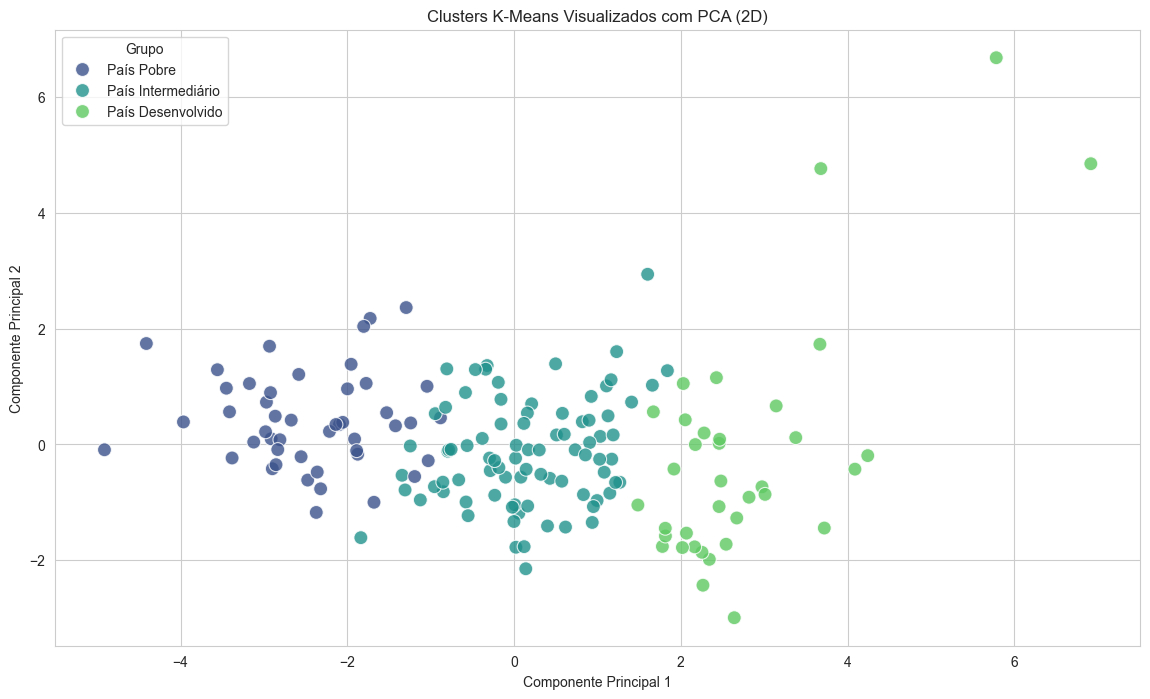

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_scaled_pca = pca.fit_transform(X_scaled_df)

df_pca = pd.DataFrame(X_scaled_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster_kmeans'] = kmeans_labels
df_pca['Grupo'] = df_pca['cluster_kmeans'].map(cluster_map)
df_pca['country'] = countries_labels_df['country']

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df_pca,
    x='PCA1',
    y='PCA2',
    hue='Grupo',
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title('Clusters K-Means Visualizados com PCA (2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Grupo')
plt.grid(True)
plt.show()